In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Times New Roman',] # windows->Heiti TC
plt.rcParams['axes.unicode_minus'] = False # windows->simhei
plt.rcParams['figure.dpi'] = 200

import geopandas as gpd
import shapely
from shapely.geometry import Point,Polygon,LineString,MultiLineString,MultiPoint,MultiPolygon

import pickle
from tqdm import tqdm
from glob import glob
import joblib
import seaborn as sns
# import northarrow
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import os

import platform
if platform.system() == "Windows":
    os.chdir(r'H:\BaiduSyncdisk\DR.MENG-Full\Y2024-002-DT-NANJING-ACCESSIBILITY-MAUP')
else:
    os.chdir(r'/Volumes/SANDISK/DR.MENG')

# Sample data

In [3]:
transit_type = 'walk'
grid_type = 'grid1000'
threshold = '1800'

In [4]:
name = os.path.basename(f'./data_access_geojson/od_{transit_type}_{grid_type}_od_{threshold}.geojson').\
    replace('.geojson','')
name

'od_walk_grid1000_od_1800'

In [5]:
grid50 = gpd.read_file('./shp/use_bounds/nanjing_grid50.shp')
buildings = gpd.read_file(f'./data_access_geojson/od_{transit_type}_buildings_{threshold}.geojson')

In [6]:
gridx = gpd.read_file(f'./data_access_geojson/{name}.geojson')
gridx = gridx.rename(columns={'net_id':'n_id'})

In [7]:
grid50.head(1)

net_id     Id                                           geometry
0  1124341  south  POLYGON ((118.79083 31.87574, 118.79087 31.876...

In [8]:
buildings.head(1)

floors building_id  access_val  \
0     2.0         b_0    0.860463   

                                            geometry  
0  POLYGON ((118.72926 31.99482, 118.72953 31.994...

In [9]:
gridx.head(1)

n_id     Id  access_val  \
0  g_3114  south         0.0   

                                            geometry  
0  POLYGON ((118.77399 31.86959, 118.77474 31.878...

In [10]:
len(grid50),len(gridx),len(buildings)

(331230, 964, 139409)

In [11]:
grid50_buildings = gpd.sjoin(grid50, buildings, predicate='intersects')

In [12]:
len(grid50_buildings)

246336

In [13]:
val_buildings = grid50_buildings.groupby(by='net_id').mean()[['access_val']].reset_index()
dt_buildings = grid50.merge(val_buildings, on='net_id')

In [14]:
# dt_buildings.explore()

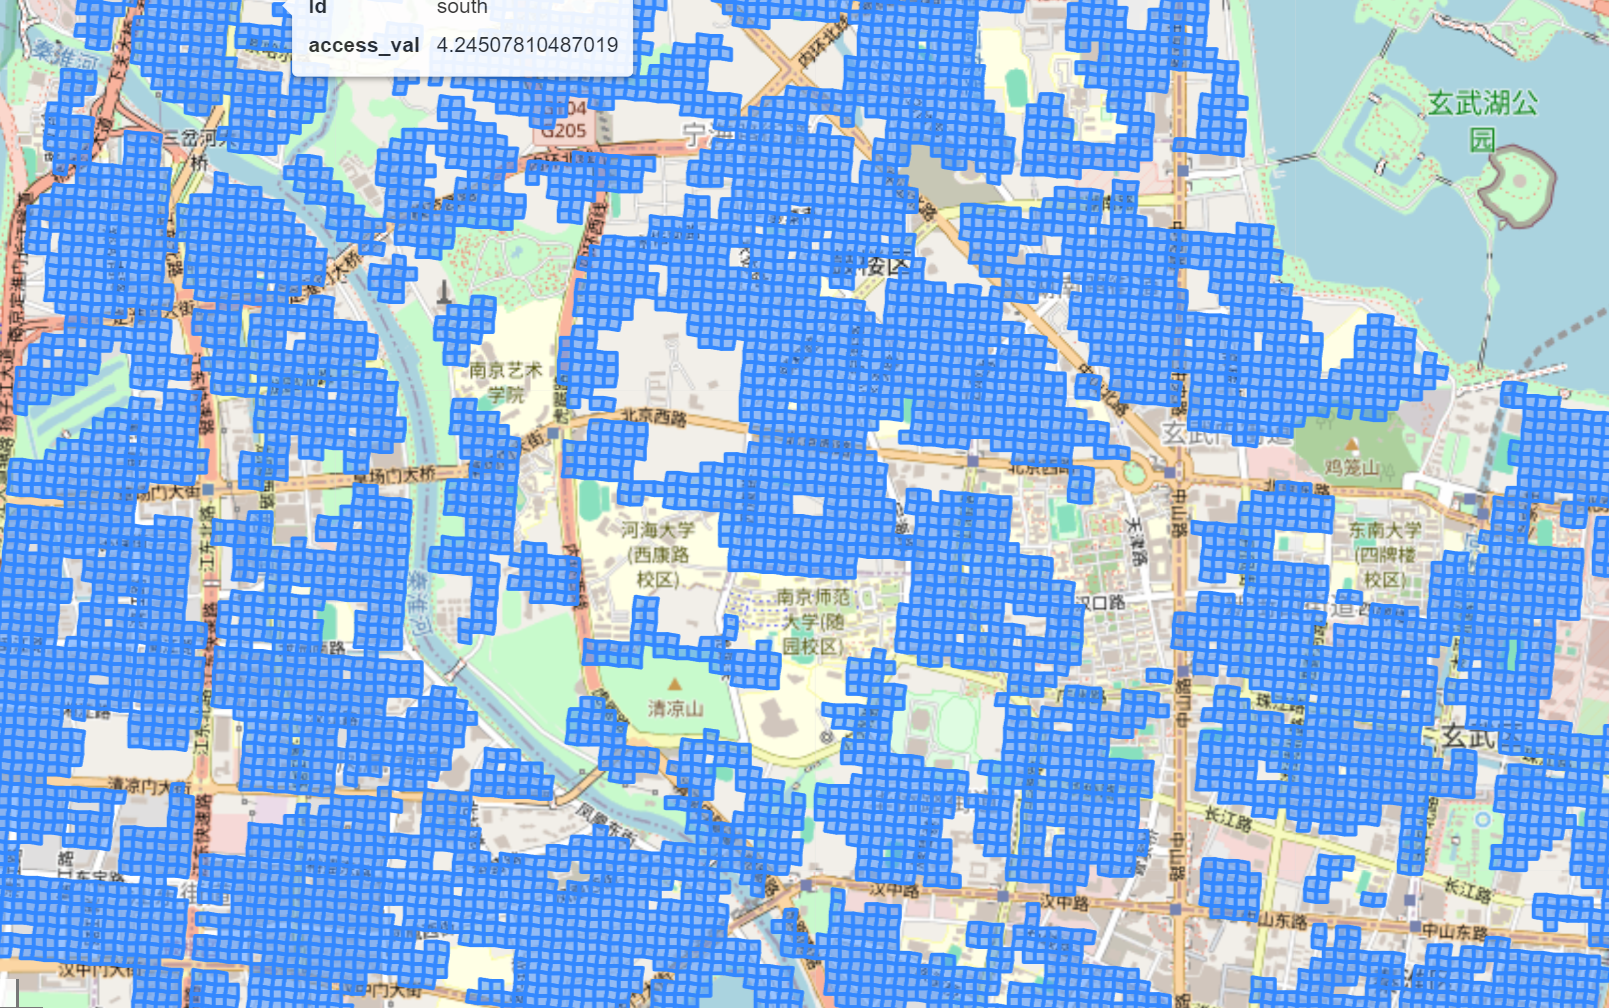

In [15]:
dt_buildings.head(1)

net_id     Id                                           geometry  \
0  1128597  south  POLYGON ((118.80621 31.87704, 118.80624 31.877...   

   access_val  
0         0.0

In [16]:
len(dt_buildings)

69684

In [17]:
grid50_gridx = gpd.sjoin(grid50, gridx, predicate='intersects')

In [18]:
val_gridx = grid50_gridx.groupby(by='net_id').mean()[['access_val']].reset_index()
dt_gridx = grid50.merge(val_gridx, on='net_id')

In [19]:
len(dt_gridx)

330870

In [20]:
dt_gridx2 = dt_gridx[dt_gridx['net_id'].isin(dt_buildings['net_id'])]

In [21]:
len(dt_gridx2)

69648

In [22]:
dt_gridx2.head(1)

net_id     Id                                           geometry  \
333  1128597  south  POLYGON ((118.80621 31.87704, 118.80624 31.877...   

     access_val  
333         0.0

In [23]:
res = dt_buildings.merge(dt_gridx2[['net_id','access_val']],on='net_id',suffixes=('_buildings','_grid'))

In [24]:
res.head(1)

net_id     Id                                           geometry  \
0  1128597  south  POLYGON ((118.80621 31.87704, 118.80624 31.877...   

   access_val_buildings  access_val_grid  
0                   0.0              0.0

In [25]:
res['buildings_label'] = res['access_val_buildings'].apply(lambda x: 'out of service' if x==0 else x)

In [26]:
res['grid_label'] = res['access_val_grid'].apply(lambda x: 'out of service' if x==0 else x)

In [27]:
res.head()

net_id     Id                                           geometry  \
0  1128597  south  POLYGON ((118.80621 31.87704, 118.80624 31.877...   
1  1128598  south  POLYGON ((118.80673 31.87701, 118.80677 31.877...   
2  1128599  south  POLYGON ((118.80725 31.87697, 118.80729 31.877...   
3  1128600  south  POLYGON ((118.80778 31.87694, 118.80781 31.877...   
4  1128601  south  POLYGON ((118.80830 31.87691, 118.80834 31.877...   

   access_val_buildings  access_val_grid buildings_label      grid_label  
0                   0.0              0.0  out of service  out of service  
1                   0.0              0.0  out of service  out of service  
2                   0.0              0.0  out of service  out of service  
3                   0.0              0.0  out of service  out of service  
4                   0.0              0.0  out of service  out of service

In [28]:
res['diff_building_grid'] = res['access_val_grid'] - res['access_val_buildings']

## 网格 - 建筑
## 如果是正值，说明网格可达性高于建筑可达性（真实值），高估了。

In [29]:
res.head(1)

net_id     Id                                           geometry  \
0  1128597  south  POLYGON ((118.80621 31.87704, 118.80624 31.877...   

   access_val_buildings  access_val_grid buildings_label      grid_label  \
0                   0.0              0.0  out of service  out of service   

   diff_building_grid  
0                 0.0

In [30]:
res['diff_building_grid'].max(), res['diff_building_grid'].min() # plot use

(1072.6846970664897, -1341.4849873308945)

In [31]:
res['diff_building_grid'].quantile(0.975), res['diff_building_grid'].quantile(0.025) # must remove outlier before modeling

(23.397590768768225, -23.05871080382093)

In [32]:
# remove outliers

res_modeling = res[(res['diff_building_grid'] < res['diff_building_grid'].quantile(0.975)) &\
           (res['diff_building_grid'] > res['diff_building_grid'].quantile(0.055))]

# Plot

In [33]:
res2 = res.copy()

In [34]:
import contextily as cx

nanjing = gpd.read_file('./shp/use_bounds/nanjing_town.shp')
center = gpd.read_file('./shp/central/nanjing_central.shp')

In [35]:
nanjing.head(1)

省    市    县      乡  index_righ     Id  \
0  江苏省  南京市  秦淮区  中华门街道           1  south   

                                            geometry  
0  POLYGON ((118.79053 31.99943, 118.79051 31.994...

In [36]:
res2x = res2.to_crs(4326)
nanjingx = nanjing.to_crs(4326)
centerx = center.to_crs(4326)

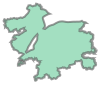

In [37]:
nanjingx['geometry'].unary_union

In [38]:
# res2x.explore()

In [39]:
nj = gpd.read_file('./parks/parks.shp')

In [40]:
nj32649 = nj.to_crs(4326)

In [41]:
sns.color_palette('coolwarm',9)

[(0.34832334141176474, 0.4657111465098039, 0.8883461629411764),
 (0.48385432959999997, 0.6220498496, 0.9748082026),
 (0.6193179451882354, 0.7441207347647059, 0.9989309188196078),
 (0.753610618, 0.830232851, 0.960871157),
 (0.8674276350862745, 0.864376599772549, 0.8626024620196079),
 (0.9473454036, 0.7946955048, 0.7169905058),
 (0.9684997476666667, 0.673977379772549, 0.5566492560470588),
 (0.9318312966, 0.5190855232, 0.4064796086),
 (0.8393649370784314, 0.32185622094117644, 0.26492398098039216)]

In [42]:
color_lst = [
                (0.09019607843137256, 0.39294117647058824, 0.6705882352941177),
                (0.2909803921568628, 0.5945098039215686, 0.7890196078431373),
                (0.5796078431372549, 0.7701960784313725, 0.8737254901960784),
                (0.8141176470588235, 0.883921568627451, 0.9498039215686275),

                '#D3D3D3',

                (0.9913725490196079, 0.7913725490196079, 0.7082352941176471),
                (0.9874509803921568, 0.5411764705882353, 0.41568627450980394),
                (0.9466666666666667, 0.26823529411764707, 0.19607843137254902),
                (0.7364705882352941, 0.08, 0.10117647058823528)
                                                        ]

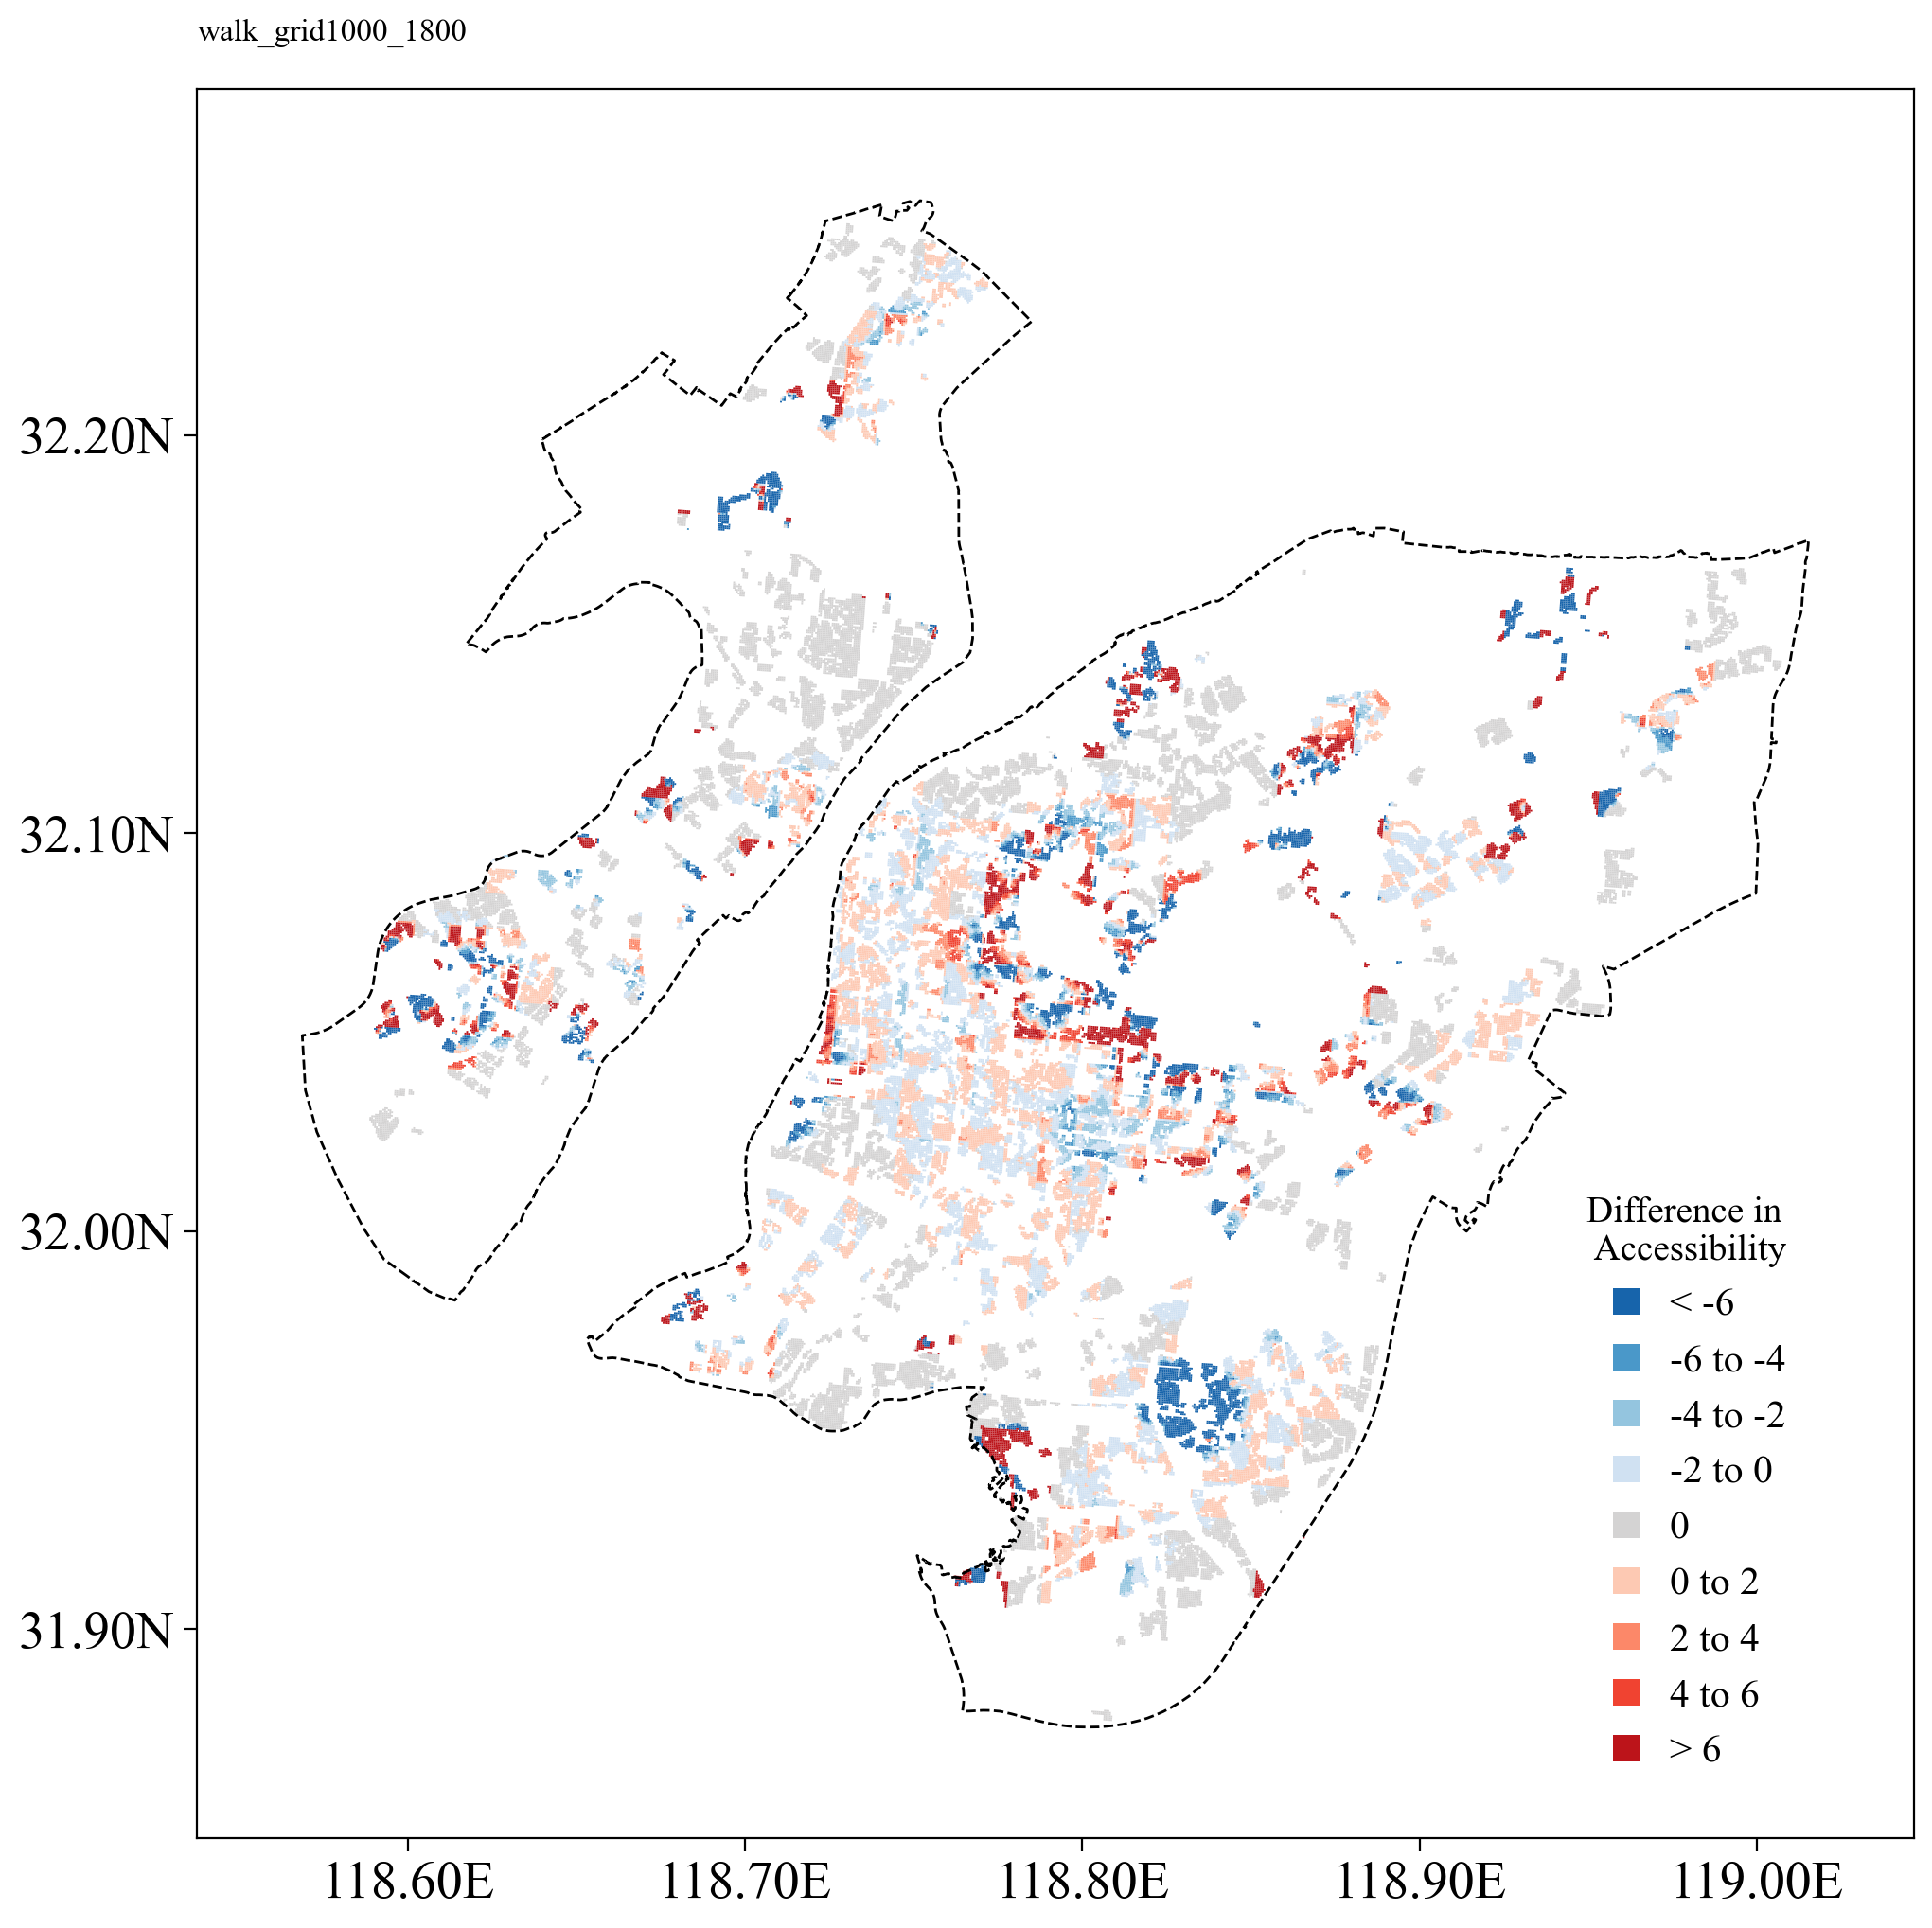

In [43]:
f, ax = plt.subplots(figsize=(12, 12))
bins = [-6, -4, -2, -0.01, 0.01, 2, 4, 6]

def return_colors_bins(bins):
    vmin, vmax = res2x['diff_building_grid'].min(), res2x['diff_building_grid'].max()
    bins2 = [i for i in bins if i >= vmin and i <= vmax]
    bins_id = [bins.index(item) for item in bins2]
    color_list2 = color_lst[bins_id[0]:bins_id[-1]+2]

    return bins2, color_list2

bins2, color_list2 = return_colors_bins(bins)
cmap = LinearSegmentedColormap.from_list('mycmap', color_list2)

fg = res2x.plot(column='diff_building_grid', scheme="userdefined",
                edgecolor='none', cmap=cmap, ax=ax, legend=True,
                legend_kwds={'loc': (0.8,0.03), 'frameon': False, 'title': 'Difference in\n Accessibility', 'title_fontsize':14, 
                             'fontsize': 15, 'handletextpad': 0.1},
                classification_kwds={'bins': bins2})


leg = fg.get_legend()

num_len = len(leg.get_texts())
for i, lbl in enumerate(leg.get_texts()):
    label_text = lbl.get_text()
    lower = label_text.split(',')[0].strip()
    upper = label_text.split(',')[1].strip()

    f_lower = float(lower)
    f_upper = float(upper)

    if i == 0:
        new_text = f'< {bins2[0]}'
        lbl.set_text(new_text)
    elif f_lower >= -0.02 and f_lower < 0.01:
        new_text = f'0'
        lbl.set_text(new_text)
    elif i== num_len-1:
        new_text = f'> {bins2[-1]}'
        lbl.set_text(new_text)
    else:
        f_lower = int(f_lower)
        f_upper = int(f_upper)

        new_text = f'{f_lower} to {f_upper}'
        lbl.set_text(new_text)


lines = leg.get_lines()
for line in lines:
    line.set_marker('s')  # 's' 表示正方形

centerx2 = centerx.copy()
centerx2['geometry'] = centerx2['geometry'].buffer(0.008)
centerx2.plot(ax=ax, lw=0, facecolor='none')

# cx.add_basemap(ax, crs=centerx2.crs, alpha=0.3,
#                source=cx.providers.MapBox.Streets, zorder=0)

centerx.plot(ax=ax, facecolor='none', edgecolor='k', lw=1, zorder=12, ls='--')
ax.tick_params(axis='both', which='major', length=5, color='k',labelsize=20)
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))  # 这里设置间隔为0.1
# ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))  # 这里设置间隔为0.1

# 自定义格式化函数
def custom_formatter1(x, pos):
    return f'{x:.2f}E'

def custom_formatter2(x, pos):
    return f'{x:.2f}N'

import matplotlib.ticker as ticker
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter2))
# xlim, ylim = (118.55, 119.05), (31.82, 32.32)
# ax.set(xlim=xlim, ylim=ylim)
# ax.set_axis_off()
ax.set_title(f'{name}\n'.replace('od_',''), loc='left')

# import northarrow
# northarrow.add_north(ax=ax, loc_x=0.81, loc_y=1.01, height=0.08, width=0.04, labelsize=16)
# northarrow.add_scalebar_geo(ax, centerx, lng=118.9, lat=32.21, length=5000, fontsize=14)

# fig.subplots_adjust(hspace=0.1, wspace=0.01)
name_save = name.replace('od_','')
# plt.savefig(f'./result/png/diff_spatial/{name_save}.png', dpi=300, bbox_inches='tight')
# plt.close()

In [2]:
import northarrow
northarrow.add_scalebar_pro?

Signature:
northarrow.add_scalebar_pro(
    ax,
    x,
    y,
    length,
    lw=1,
    fontsize=12,
    divd=8,
    sub=15,
)
Docstring:
画一个比例尺带'N'文字注释
主要参数如下    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
:param x: 起点x坐标
:param y: 起点y坐标
:param length: 一个刻度长度（米）
:param lw: 线宽
:param fs: 文字大小
:return
File:      c:\users\ps\anaconda3\lib\site-packages\northarrow.py
Type:      function